In [1]:
import copy
import multiprocessing as mp
from pathlib import Path
import random
import sys
from typing import Optional

import datamol as dm
import lohi_splitter as lohi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polaris as po
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger
import seaborn as sns
from splito._scaffold_split import get_scaffold
from sklearn.metrics import r2_score
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

sys.path.append('../src')
from utils import ECFP_from_smiles, tanimoto_similarity, standardize_smiles

[17:48:00] Initializing Normalizer


In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
benchmark = po.load_benchmark("polaris/adme-fang-solu-1")

2024-06-21 17:48:01.984 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-21 17:48:01.994 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


In [4]:
train_hi = pd.read_csv('~/data/splits/hi/train.tsv', sep='\t')
train_hi_with_external = pd.read_csv('~/data/splits/hi/train_with_external.tsv', sep='\t')
valid_hi = pd.read_csv('~/data/splits/hi/valid.tsv', sep='\t')
train = pd.read_csv('~/data/train.tsv', sep='\t')
test = pd.read_csv('~/data/test.tsv', sep='\t')
train_hi['S'] = 10**train_hi['logS']
train_hi_with_external['S'] = 10**train_hi_with_external['logS']
valid_hi['S'] = 10**valid_hi['logS']
train['S'] = 10**train['logS']

In [5]:
train_hi_with_external = train_hi_with_external[train_hi_with_external['logS'] >= -1.].reset_index(drop=True)
train_hi_with_external.shape

(2927, 3)

In [6]:
logS_mean, logS_std = train['logS'].mean(), train['logS'].std()
S_mean, S_std = train['S'].mean(), train['S'].std()

train_hi['logS_norm'] = (train_hi['logS'] - logS_mean) / logS_std
train_hi['S_norm'] = (train_hi['S'] - S_mean) / S_std
valid_hi['logS_norm'] = (valid_hi['logS'] - logS_mean) / logS_std
valid_hi['S_norm'] = (valid_hi['S'] - S_mean) / S_std
train['logS_norm'] = (train['logS'] - logS_mean) / logS_std
train['S_norm'] = (train['S'] - S_mean) / S_std

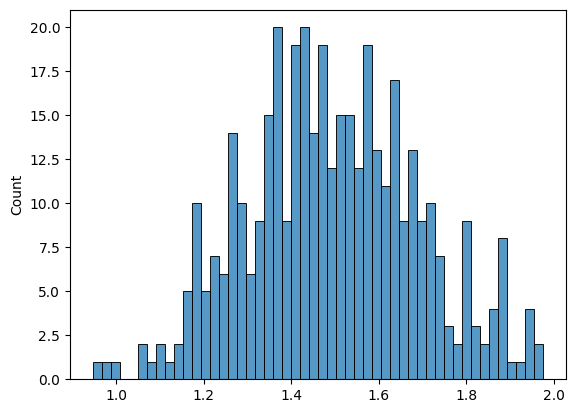

In [7]:
y_pred = 0.2 * np.random.randn(len(test)) + 1.5
sns.histplot(y_pred, bins=50);

In [8]:
results = benchmark.evaluate(y_pred)
results

{
  "name": null,
  "description": "",
  "tags": [],
  "user_attributes": {},
  "owner": null,
  "polaris_version": "dev",
  "benchmark_name": "adme-fang-SOLU-1",
  "benchmark_owner": {
    "slug": "polaris",
    "external_id": "org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu",
    "type": "organization"
  },
  "github_url": null,
  "paper_url": null,
  "contributors": null,
  "artifact_id": null,
  "benchmark_artifact_id": "polaris/adme-fang-solu-1",
  "results": [
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_absolute_error",
      "Score": 0.5199767201
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_squared_error",
      "Score": 0.6536645301
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "r2",
      "Score": -0.2056257511
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "spearmanr",
      "Score": -0.0098429035
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "pearsonr",
      "Score": -0.0118886754
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "explained_var",
      "Score": -0.0784179963
    }
  ]
}

In [9]:
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd

In [10]:
def renumerate_smiles(smiles):
    """Perform a randomization of a SMILES string
    must be RDKit sanitizable"""
    m = Chem.MolFromSmiles(smiles)
    ans = list(range(m.GetNumAtoms()))
    np.random.shuffle(ans)
    nm = Chem.RenumberAtoms(m,ans)
    smiles = Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True)

    return smiles

def randomly_mask_smiles(mol_sentence: str, mol_masking_val: float, mask_token: int) -> str:
    mask = torch.rand((len(mol_sentence),)) >= mol_masking_val
    masked_mol_sentence = ''.join([
        char if mask[i] else mask_token for i, char in enumerate(mol_sentence)
    ])

    return masked_mol_sentence

class TransformersTokenizer:
    def __init__(self, pretrained_model_name_or_path, max_length, padding, truncation, do_lower_case) -> None:
        if pretrained_model_name_or_path == 'ibm/MoLFormer-XL-both-10pct':
            self.tokenizer = AutoTokenizer.from_pretrained(
                pretrained_model_name_or_path, do_lower_case=do_lower_case, trust_remote_code=True
            )
        else:
            print(f'Loading an unknown tokenizer: {pretrained_model_name_or_path}')
            self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path, use_fast=False, max_len=128)
        self.max_length = max_length
        self.padding = padding
        self.truncation = truncation

    def tokenize(self, seq: str) -> tuple[list[int], list[int]]:
        raise NotImplementedError()

    @property
    def pad_token_id(self) -> int:
        return self.tokenizer.pad_token_id


class MolTransformersTokenizer(TransformersTokenizer):
    def __init__(self, pretrained_model_name_or_path, max_length=128, padding=False, truncation=True) -> None:
        super().__init__(
            pretrained_model_name_or_path=pretrained_model_name_or_path,
            max_length=max_length,
            padding=padding,
            truncation=truncation,
            do_lower_case=False
        )

    def tokenize(self, smiles: str) -> tuple[list[int], list[int]]:
        tokenized = self.tokenizer(smiles, max_length=self.max_length,
                                   padding=self.padding, truncation=self.truncation)
        
        return tokenized['input_ids'], tokenized['attention_mask']


class BasicTokenizationDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: TransformersTokenizer, smiles_col: str,
                 randomize_smiles: bool = False, mol_masking_prob: float = 0.3, mol_masking_val: float = 0.0,
                 truncate: bool = False, eval_mode: bool = True) -> None:
        super().__init__()
        self.data = data
        self.smiles_col = smiles_col
        self.randomize_smiles = randomize_smiles
        self.mol_masking_prob = mol_masking_prob
        self.mol_masking_val = mol_masking_val
        self.tokenizer = tokenizer
        self.truncate = truncate
        self.eval_mode = eval_mode

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        smiles_orig = self.data.iloc[index][self.smiles_col]

        if self.randomize_smiles and (np.random.rand() < 0.5):
            smiles = renumerate_smiles(smiles_orig)
        else:
            smiles = smiles_orig
        if (self.mol_masking_val > 0.) and (np.random.rand() < self.mol_masking_prob):
            smiles = randomly_mask_smiles(
                smiles, self.mol_masking_val, self.tokenizer.tokenizer.mask_token
            )

        if not self.eval_mode:
            label_logs = torch.tensor(self.data.iloc[index]['logS'], dtype=torch.float32)
            label_s = torch.tensor(self.data.iloc[index]['S'], dtype=torch.float32)
        input_ids, attention_mask = self.tokenizer.tokenize(smiles)

        sample = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        if not self.eval_mode:
            sample['label_logs'] = label_logs
            sample['label_s'] = label_s

        return sample

    def collate_fn(self, samples):
        input_ids = [sample['input_ids'] for sample in samples]
        attention_mask = [sample['attention_mask'] for sample in samples]
        input_ids, attention_mask = BasicTokenizationDataset.pad_sequences(
            input_ids, attention_mask, self.tokenizer.pad_token_id
        )

        batch = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        if not self.eval_mode:
            batch['label_logs'] = torch.stack([sample['label_logs'] for sample in samples])
            batch['label_s'] = torch.stack([sample['label_s'] for sample in samples])

        return batch

    @staticmethod
    def pad_sequences(input_ids, attention_mask, pad_token_id=0):
        max_seq_len = max([len(inp) for inp in input_ids])
        input_ids_ = torch.full((len(input_ids), max_seq_len), pad_token_id, dtype=torch.long)
        attention_mask_ = torch.zeros((len(input_ids), max_seq_len), dtype=torch.bool)
        for i, (inp, att_mask) in enumerate(zip(input_ids, attention_mask)):
            input_ids_[i, :len(inp)] = torch.tensor(inp, dtype=torch.long)
            attention_mask_[i, :len(att_mask)] = torch.tensor(att_mask, dtype=torch.long)

        return input_ids_, attention_mask_

In [12]:
class Model(nn.Module):
    def __init__(self, model_name_or_path: str, num_classes: int) -> None:
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name_or_path, trust_remote_code=True, deterministic_eval=True)
        self.linear1 = nn.Linear(self.model.config.hidden_size, 512)
        self.linear2 = nn.Linear(self.model.config.hidden_size, 512)
        # self.dropout = nn.Dropout(0.2)
        self.classifier_logs = nn.Linear(512, num_classes)
        self.classifier_s = nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask)
        x = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).type(torch.bool)
        x[~input_mask_expanded] = torch.finfo(torch.float16).min  # Set padding tokens to large negative value
        feats_max_pool = F.max_pool1d(x.permute(0, 2, 1), kernel_size=x.size(1)).squeeze(-1)
        # feats_avg_pool = (x * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(-1).unsqueeze(-1)

        # x = torch.cat([self.linear1(feats_max_pool), self.linear2(feats_avg_pool)], dim=1)
        x = self.linear1(feats_max_pool)
        # x = self.dropout(x)
        output_logs = self.classifier_logs(x)
        output_s = self.classifier_s(x)

        return output_logs, output_s

In [13]:
def train_step(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0.
    for batch in tqdm(data_loader):
        batch = {k: v.cuda() for k, v in batch.items()}
        input_ids, attention_mask = batch['input_ids'], batch['attention_mask']
        label_logs, label_s = batch['label_logs'], batch['label_s']
        output_logs, output_s = model(input_ids, attention_mask)
        output_logs, output_s = output_logs.squeeze(-1), output_s.squeeze(-1)
        loss_logs = criterion(output_logs, label_logs)
        loss = loss_logs
        # loss_s = criterion(output_s, label_s)
        # loss = loss_logs + loss_s
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

def eval_step(model, data_loader, test_mode=False):
    model.eval()
    predictions_logs, predictions_s = [], []
    for batch in data_loader:
        batch = {k: v.cuda() for k, v in batch.items()}
        with torch.no_grad():
            output_logs, output_s = model(batch['input_ids'], batch['attention_mask'])
            output_logs, output_s = output_logs.squeeze(-1), output_s.squeeze(-1)
        predictions_logs.append(output_logs.detach().cpu().numpy())
    predictions_logs = np.concatenate(predictions_logs)
    # predictions_logs = predictions_logs * logS_std + logS_mean

    if test_mode:
        return None, predictions_logs
    else:
        r2 = r2_score(data_loader.dataset.data['logS'], predictions_logs)
        return r2, predictions_logs

In [25]:
N_EPOCHS = 30
BATCH_SIZE = 128
LR = 1e-4

model = Model('ibm/MoLFormer-XL-both-10pct', 1)
model = model.cuda()
model_submit = Model('ibm/MoLFormer-XL-both-10pct', 1)
model_submit = model_submit.cuda()
best_model, best_model_submit = None, None

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer_submit = torch.optim.Adam(model_submit.parameters(), lr=LR)
criteria_mse = nn.MSELoss()

tokenizer = MolTransformersTokenizer("ibm/MoLFormer-XL-both-10pct", max_length=128)
train_hi_dataset = BasicTokenizationDataset(
    train_hi, tokenizer, randomize_smiles=True, smiles_col='smiles', eval_mode=False, mol_masking_val=0.15
)
valid_hi_dataset = BasicTokenizationDataset(valid_hi, tokenizer, smiles_col='smiles')
train_dataset = BasicTokenizationDataset(
    train, tokenizer, randomize_smiles=True, smiles_col='smiles', eval_mode=False, mol_masking_val=0.15
)
test_dataset = BasicTokenizationDataset(test, tokenizer, smiles_col='smiles')

train_hi_dataloader = DataLoader(train_hi_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_hi_dataset.collate_fn)
valid_hi_dataloader = DataLoader(valid_hi_dataset, batch_size=512, shuffle=False, collate_fn=valid_hi_dataset.collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=test_dataset.collate_fn)

best_r2 = -np.inf
torch.set_grad_enabled(True)
for epoch in range(N_EPOCHS):
    train_hi_loss = train_step(model, train_hi_dataloader, optimizer, criteria_mse)
    valid_hi_r2, _ = eval_step(model, valid_hi_dataloader)
    print(f'Epoch: {epoch}, Train Hi Loss: {train_hi_loss:.4f} Valid Hi R2: {valid_hi_r2:.2%}')

    train_submit_loss = train_step(model_submit, train_dataloader, optimizer_submit, criteria_mse)
    print(f'Epoch: {epoch}, Train Hi Loss: {train_hi_loss:.4f} Train submit Loss: {train_submit_loss:.4f} Valid Hi R2: {valid_hi_r2:.2%}')

    if valid_hi_r2 > best_r2:
        best_r2 = valid_hi_r2
        best_model_submit = copy.deepcopy(model_submit)
        best_model = copy.deepcopy(model)

print(f'Best VALID R2: {best_r2:.2%}')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch: 0, Train Hi Loss: 1.0718 Valid Hi R2: 9.73%


100%|██████████| 13/13 [00:03<00:00,  3.34it/s]


Epoch: 0, Train Hi Loss: 1.0718 Train submit Loss: 0.7717 Valid Hi R2: 9.73%


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch: 1, Train Hi Loss: 0.5328 Valid Hi R2: 7.00%


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 1, Train Hi Loss: 0.5328 Train submit Loss: 0.4702 Valid Hi R2: 7.00%


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Epoch: 2, Train Hi Loss: 0.3831 Valid Hi R2: 9.25%


100%|██████████| 13/13 [00:03<00:00,  3.33it/s]


Epoch: 2, Train Hi Loss: 0.3831 Train submit Loss: 0.3475 Valid Hi R2: 9.25%


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch: 3, Train Hi Loss: 0.3544 Valid Hi R2: 14.65%


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 3, Train Hi Loss: 0.3544 Train submit Loss: 0.2928 Valid Hi R2: 14.65%


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Epoch: 4, Train Hi Loss: 0.3294 Valid Hi R2: 22.65%


100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch: 4, Train Hi Loss: 0.3294 Train submit Loss: 0.2732 Valid Hi R2: 22.65%


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Epoch: 5, Train Hi Loss: 0.2919 Valid Hi R2: 22.28%


100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 5, Train Hi Loss: 0.2919 Train submit Loss: 0.2688 Valid Hi R2: 22.28%


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Epoch: 6, Train Hi Loss: 0.2664 Valid Hi R2: 31.06%


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch: 6, Train Hi Loss: 0.2664 Train submit Loss: 0.2487 Valid Hi R2: 31.06%


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Epoch: 7, Train Hi Loss: 0.2479 Valid Hi R2: 31.45%


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 7, Train Hi Loss: 0.2479 Train submit Loss: 0.2290 Valid Hi R2: 31.45%


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Epoch: 8, Train Hi Loss: 0.2326 Valid Hi R2: 30.61%


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch: 8, Train Hi Loss: 0.2326 Train submit Loss: 0.2198 Valid Hi R2: 30.61%


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch: 9, Train Hi Loss: 0.2286 Valid Hi R2: 26.25%


100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch: 9, Train Hi Loss: 0.2286 Train submit Loss: 0.2149 Valid Hi R2: 26.25%


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch: 10, Train Hi Loss: 0.2142 Valid Hi R2: 28.79%


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch: 10, Train Hi Loss: 0.2142 Train submit Loss: 0.2160 Valid Hi R2: 28.79%


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Epoch: 11, Train Hi Loss: 0.1933 Valid Hi R2: 29.78%


100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch: 11, Train Hi Loss: 0.1933 Train submit Loss: 0.1910 Valid Hi R2: 29.78%


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch: 12, Train Hi Loss: 0.1800 Valid Hi R2: 27.83%


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch: 12, Train Hi Loss: 0.1800 Train submit Loss: 0.2019 Valid Hi R2: 27.83%


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Epoch: 13, Train Hi Loss: 0.1640 Valid Hi R2: 29.23%


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 13, Train Hi Loss: 0.1640 Train submit Loss: 0.1874 Valid Hi R2: 29.23%


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Epoch: 14, Train Hi Loss: 0.1527 Valid Hi R2: 31.86%


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 14, Train Hi Loss: 0.1527 Train submit Loss: 0.1564 Valid Hi R2: 31.86%


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Epoch: 15, Train Hi Loss: 0.1489 Valid Hi R2: 25.67%


100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch: 15, Train Hi Loss: 0.1489 Train submit Loss: 0.1525 Valid Hi R2: 25.67%


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Epoch: 16, Train Hi Loss: 0.1417 Valid Hi R2: 25.17%


100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch: 16, Train Hi Loss: 0.1417 Train submit Loss: 0.1546 Valid Hi R2: 25.17%


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch: 17, Train Hi Loss: 0.1496 Valid Hi R2: 22.02%


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch: 17, Train Hi Loss: 0.1496 Train submit Loss: 0.1628 Valid Hi R2: 22.02%


 20%|██        | 2/10 [00:00<00:03,  2.41it/s]


KeyboardInterrupt: 

In [26]:
_, test_predictions_logs = eval_step(best_model_submit, test_dataloader, test_mode=True)
results = benchmark.evaluate(test_predictions_logs)
results

{
  "name": null,
  "description": "",
  "tags": [],
  "user_attributes": {},
  "owner": null,
  "polaris_version": "dev",
  "benchmark_name": "adme-fang-SOLU-1",
  "benchmark_owner": {
    "slug": "polaris",
    "external_id": "org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu",
    "type": "organization"
  },
  "github_url": null,
  "paper_url": null,
  "contributors": null,
  "artifact_id": null,
  "benchmark_artifact_id": "polaris/adme-fang-solu-1",
  "results": [
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_absolute_error",
      "Score": 0.3955394886
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_squared_error",
      "Score": 0.359670682
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "r2",
      "Score": 0.3366196021
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "spearmanr",
      "Score": 0.5382854166
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "pearsonr",
      "Score": 0.6009388904
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "explained_var",
      "Score": 0.3417272786
    }
  ]
}

In [34]:
test_molformer_preds = test_predictions_logs
test_xgb_preds = np.load('/home/ubuntu/data/Results/XGB_results.npy')
test_preds = 0.5 * test_molformer_preds + 0.5 * test_xgb_preds

In [33]:
results = benchmark.evaluate(test_preds)
results.name = 'ML4DD-team10'
results.description = 'https://docs.google.com/document/d/1sjtQgNrN6tdnXqJiUjNT_nHbRnFH632FqWikktldiM4/edit?usp=sharing'
results.github_url = 'https://github.com/VladVin/bind-them-all'
# results.contributors = ['vladvin', 'zhwm', 'BenjaminWeiser' 'anoushka2000']
results

{
  "name": "ML4DD-team10",
  "description": "https://docs.google.com/document/d/1sjtQgNrN6tdnXqJiUjNT_nHbRnFH632FqWikktldiM4/edit?usp=sharing",
  "tags": [],
  "user_attributes": {},
  "owner": null,
  "polaris_version": "dev",
  "benchmark_name": "adme-fang-SOLU-1",
  "benchmark_owner": {
    "slug": "polaris",
    "external_id": "org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu",
    "type": "organization"
  },
  "github_url": "https://github.com/VladVin/bind-them-all",
  "paper_url": null,
  "contributors": null,
  "artifact_id": null,
  "benchmark_artifact_id": "polaris/adme-fang-solu-1",
  "results": [
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_absolute_error",
      "Score": 0.4103523524
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_squared_error",
      "Score": 0.3444609919
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "r2",
      "Score": 0.3646725148
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "spearmanr",
      "Score": 0.5689948257
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "pearsonr",
      "Score": 0.6253709212
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "explained_var",
      "Score": 0.3694326684
    }
  ]
}

In [29]:
results.upload_to_hub(owner='vladvin');

2024-06-21 17:57:48.909 | SUCCESS  | polaris.hub.client:upload_results:492 - Your result has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/polaris/adme-fang-SOLU-1/jW64wueaTFK6YhvwHoRdA
